In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'  #GPU id
# os.environ["CUDA_LAUNCH_BLOCKING"]='1'
# os.environ['MASTER_ADDR'] = 'localhost'
# os.environ['MASTER_PORT'] = '5678'

import argparse
import os
import pprint
# import shutil
# import sys

import logging
import time
import timeit
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
# import torch.backends.cudnn as cudnn
import torch.optim
# from torch.utils.data.distributed import DistributedSampler
from tensorboardX import SummaryWriter
# import segmentation_models_pytorch as smp

# import tools._init_paths
# import models
# import datasets
from lib.config import config
from lib.config import update_config
# from core.criterion import CrossEntropy, OhemCrossEntropy
from lib.core.bdl_losses import GeneralizedDice, SurfaceLoss, DiceLoss
# from utils.modelsummary import get_model_summary
# from utils.utils import create_logger, FullModel, get_rank
from lib.utils.utils import create_logger
# from lib.core.function_video import train, validate, test
# from lib.datasets.pitVideoDataset import PitDataset
# from lib.models.segland_hrnet_mstcn import HighResolutionNet
from lib.core.function_video_nMasks import train, validate, test
from lib.datasets.pitVideoDataset_nMasks import PitDataset
from lib.models.segland_hrnet_convLSTM import HighResolutionNet
import random



seed = 2
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


config.DATASET.TRAIN_SET = 'Centroids_605_fold1_train.csv'
config.DATASET.TEST_SET = 'Centroids_605_fold1_val.csv'
# video clips 
config.DATASET.CLIPS = '/home/zhehua/data/PitDatasets/Landmarks_2992_pseudo_structure_4.csv'
# self.preprocessing = preprocessing
config.DATASET.ROOT = '/home/zhehua/codes/PitVideo-Segment-Landmark/data/video_seg_centroid_5fold_4structure_pseudo'
config.DATASET.CSV_FILE_ROOT = 'fold1'
config.DATASET.IMAGE_ROOT = '/home/zhehua/data/PitDatasets/Images_5FPS'
config.DATASET.MASK_ROOT = '/home/zhehua/data/PitDatasets/Masks_pseudo'

def main():

    # distributed = False
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device('cuda:{}'.format(args.local_rank))

    # build model
    # model = HighResolutionNet(config)
    # model.init_weights(config.MODEL.PRETRAINED)              
    # model = model.to(device)
    # model = torch.nn.DataParallel(model)

    # # Test net output
    # dump_input = torch.rand((1, 5, 3, 720, 1296)).to(device)
    # seg, cpts = model(dump_input)

    train_dataset = PitDataset(config, is_train=True, to_tensor=True)
    test_dataset = PitDataset(config, is_train=False, to_tensor=True)
    
    return train_dataset, test_dataset


train_dataset, test_dataset = main()


[[[ 6 10  4]
  [ 2  5  0]
  [ 4  6  0]
  ...
  [10 11  6]
  [10 11  6]
  [ 6  8  4]]

 [[ 6 10  4]
  [ 5  8  4]
  [ 5  8  4]
  ...
  [10 11  6]
  [ 8 10  5]
  [ 6  8  4]]

 [[ 5  8  4]
  [ 5  8  4]
  [ 6 10  4]
  ...
  [ 8 10  5]
  [ 8 10  5]
  [ 6  8  4]]

 ...

 [[ 5  8  4]
  [ 5  8  4]
  [ 5  8  4]
  ...
  [ 8 10  5]
  [ 8 10  5]
  [ 5  6  2]]

 [[ 5  8  4]
  [ 5  8  4]
  [ 5  8  4]
  ...
  [11 12  8]
  [10 11  6]
  [ 6  8  4]]

 [[ 6 10  4]
  [ 5  8  4]
  [ 5  8  4]
  ...
  [10 11  6]
  [ 8 10  5]
  [ 5  6  2]]]


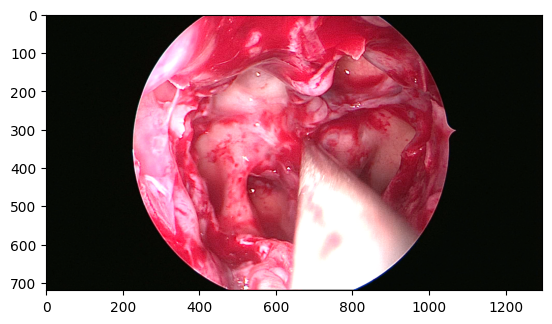

In [5]:
import cv2, numpy
frames_sequence, mask_sequence, cpts_sequence, cpts_presence_sequence, labeled_frame_name, dist_map_tensor_sequence = train_dataset[0]

# print(cpts_sequence, labeled_frame_name)
# image = cv2.cvtColor(numpy.array(frames_sequence[2]), cv2.COLOR_BGR2RGB)
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
frames_sequence = frames_sequence.permute(0, 2, 3, 1).cpu().numpy()
image = frames_sequence[1]
image = ((image*std+mean)*255.0).astype('uint8')
print(image)
plt.imshow(image)

In [ ]:
frames_sequence, mask_sequence, cpts_sequence, cpts_presence_sequence, labeled_frame_name, dist_map_tensor_sequence = train_dataset[0]
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
image = frames_sequence[-1].permute(1, 2, 0).cpu().numpy()
print(image)

In [ ]:
image = (image*std+mean)*255.0
# landmarks = cpts*cpts_presence
print(image)

In [ ]:
plt.imshow(image)

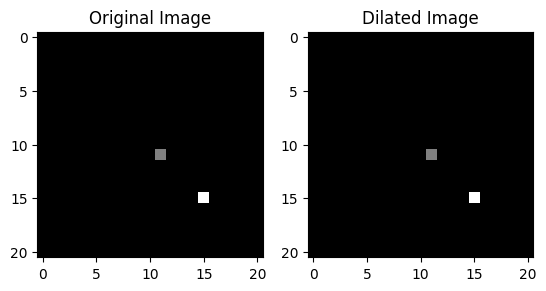

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = np.zeros((21, 21), dtype=np.uint8)
image[11,11]=100
image[15, 15]=200

# 读取输入图像
# image = cv2.imread('input.jpg', cv2.IMREAD_GRAYSCALE)

# 定义卷积核
kernel = np.ones((1, 1), np.uint8)

# 对图像进行膨胀操作
dilated_image = cv2.dilate(image, kernel, iterations=1)

# 使用 matplotlib 显示结果
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Dilated Image')
plt.imshow(dilated_image, cmap='gray')

plt.show()
